SAS & HSE, Applied Time Series Forecasitng , Winter 2022 

<font color="blue"> Lesson #6: Using exogenous Veriables in ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - exogenious variables, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
# from utils import qualityMACAPE, qualityRMSE
import warnings, pylab
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels
import statsmodels.api as sm

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-g3nv95pp
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-g3nv95pp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
ERROR: Package 'statsmodels' requires a different Python: 3.7.12 not in '>=3.8'


# ARIMA with exogenous Variables
**Questions**
  * How to provide independent variables into ARIMA?
  * Should Seasonal Differencing transformation be applied to exogenous variables  if it should to target time series?
    - Usually, Yes 
  * Should Trend Differencing transformation be applied to exogenous variables  if it should to target time series?
    - Usually, Yes 
  * Should BoxCox transformation be applied to exogenous variables if it should to target time series?
   - Usually, No

Time Series model with exogenous variable:

* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* Idea to include exogenous variables
$$z_t = u_t + \sum_{k=1}^K \omega_k\cdot X^k_t$$
$X^k_t~-$ exogenous variable time series, 

* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}u_t = \underbrace{\sum_{i=1}^{p} \alpha_iu_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}\left(z_t-\sum_{k=1}^K \omega_k\cdot X^k_t\right) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Using exogenous variables in ARIMA models

## Energy Consumption

In [3]:
# energy_ts = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', parse_dates={'Timestamp': pd.to_datetime('Date', errors='coerce')}, index_col='Timestamp')
en_ts =pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/energy_consump.csv', decimal='.', parse_dates=['Date'], dayfirst=False, index_col='Date')
en_ts.index.names=['Timestamp']

# Working only Hub=Center and ZSP=FZSZOE27
energy_ts= en_ts[(en_ts['ZSP']=='FZSZOE27') & (en_ts['Hub']=='Center')]
# energy_ts.tail()

In [4]:
energy_ts.columns

Index(['Hub', 'ZSP', 'EnergyConsump', 'Temp1', 'Temp2', 'Temp3', 'Temp4',
       'Temp5', 'Temp6', 'Temp7', 'Saturday', 'Sunday', 'Temp1_South_Less',
       'Temp2_South_Less', 'Temp3_South_Less', 'Temp4_South_Less',
       'Temp1_South_Gr', 'Temp2_South_Gr', 'Temp3_South_Gr', 'Temp4_South_Gr'],
      dtype='object')

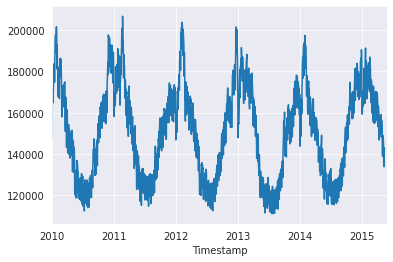

In [5]:
# See Year-Seasonality
energy_ts['EnergyConsump'].plot()

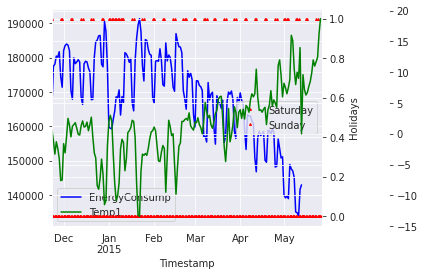

In [6]:
# See dependence on other varibales
fig, ax = plt.subplots()
ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=0.75)

energy_ts['EnergyConsump'].tail(186).plot(ax = ax,  style='b-')
energy_ts[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='r', marker = '^', markersize = 2.0, linewidth=0.0)
energy_ts['Temp1'].tail(186).plot(ax = ax3,  style='g-')

lines = ax.get_lines() + ax3.get_lines() #  ax2.get_lines() 
ax.legend(lines, [l.get_label() for l in lines], loc='lower left')
# uncomment to save the figure
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.png', bbox_inches='tight', pad_inches=0) # 
# plt.savefig('../Lecture_TS_Forecasting/pic/Energy_WeekSeasonality.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

In [7]:
# Stationary test
kpss_stat= stattools.kpss(energy_ts['EnergyConsump'].dropna())
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.096630, 
pvalue: 0.10 
maximal Lag: 26 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


## Analysis of original data

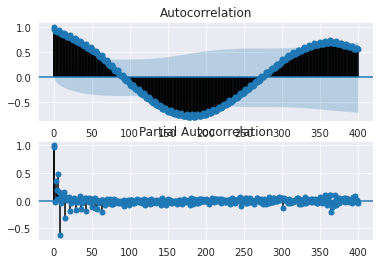

In [8]:
# ACF and PACF
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(energy_ts['EnergyConsump'].dropna(), lags=400, ax=ax2)

**Question**
 - Can we use thiss ACF, PACF for choosing $p$,$q$?

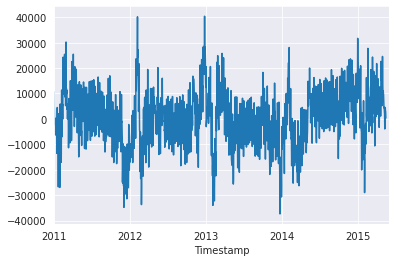

In [9]:
# Differencing
s = 365
dif365_energy = (energy_ts[energy_ts.columns[2:]] - energy_ts[energy_ts.columns[2:]].shift(s))[s:]
dif365_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

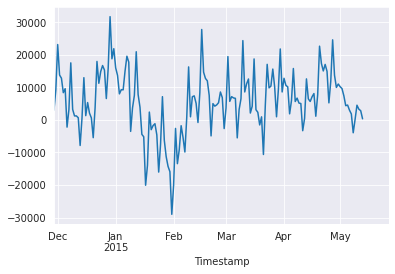

In [10]:
# Look closer
dif365_energy['EnergyConsump'].tail(180).plot()

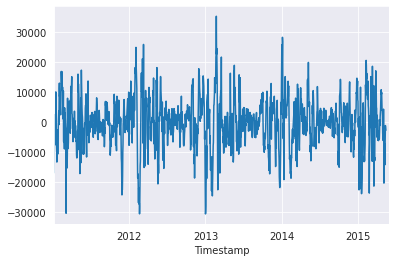

In [11]:

s=7
dif7_dif365_energy = (dif365_energy - dif365_energy.shift(s))[s:]
dif7_dif365_energy['EnergyConsump'].plot()

**Question:**
 * Is this TS stationary?

In [12]:
# Stationarity test
kpss_stat= stattools.kpss(np.array(dif7_dif365_energy['EnergyConsump'].dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.009940, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* It seems that TS is stationary


**Question:** 
  * Are TS for exogenious variables stationary?

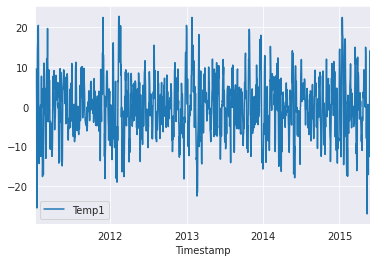

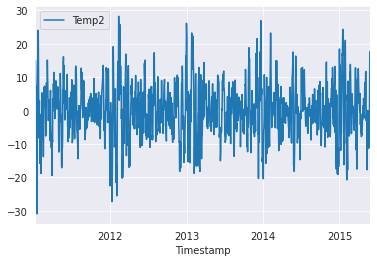

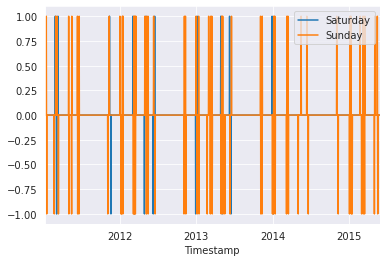

In [13]:
# plot grap for the individual variables
dif7_dif365_energy[['Temp1']].plot()
dif7_dif365_energy[['Temp2']].plot()
dif7_dif365_energy[['Saturday', 'Sunday']].plot()

In [14]:
# TODO: build KPSS test for all exog variables
kpss_stat= stattools.kpss(np.array(dif7_dif365_energy['Temp1'].dropna()))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.012288, 
pvalue: 0.10 
maximal Lag: 24 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


**Questions**:
  * What is $d$ and $D$ values for ARIMA?

  ARIMA(p, d = 0, q) x (P, D =1 , Q)_s=7  

## ARIMA for the stationary TS

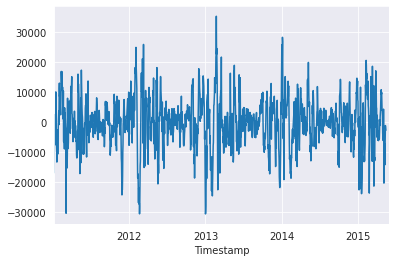

In [15]:
dif7_dif365_energy['EnergyConsump'].plot()

In [16]:
# apply regression for the TS after differencing
exogs = dif7_dif365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']][dif7_dif365_energy.index<'2015-05-01']
extra_exogs = dif7_dif365_energy[['Temp1', 'Temp2', 'Saturday','Sunday']]
ts = dif7_dif365_energy[['EnergyConsump']][dif7_dif365_energy.index<'2015-05-01']

In [17]:
# Only regressors
arima_mod000 = sm.tsa.ARIMA(endog = ts, order = (0,0,0), exog=exogs).fit()
print(arima_mod000.params)
print(arima_mod000.aic, arima_mod000.bic, arima_mod000.hqic)

const          36.114920
Temp1        -455.754651
Temp2         -94.747830
Saturday    -8821.376321
Sunday     -10395.544799
dtype: float64
32194.232078361285 32226.40033093515 32206.187039891905


In [18]:
print(arima_mod000.summary())

                              ARMA Model Results                              
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                     ARMA(0, 0)   Log Likelihood              -16091.116
Method:                           css   S.D. of innovations           6661.726
Date:                Tue, 15 Feb 2022   AIC                          32194.232
Time:                        09:37:23   BIC                          32226.400
Sample:                    01-08-2011   HQIC                         32206.187
                         - 04-30-2015                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.1149    167.914      0.215      0.830    -292.991     365.220
Temp1       -455.7547     38.739    -11.765      0.000    -531.681    -379.828
Temp2        -94.7478     34.757     -2.726      0.0

### Defining $p, P, q, Q$

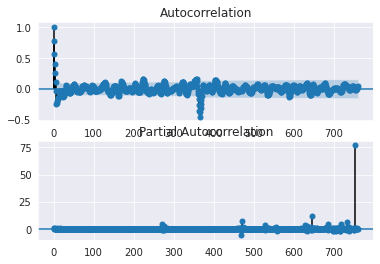

In [19]:
# acf for difference TS
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=760, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=760, ax=ax2)

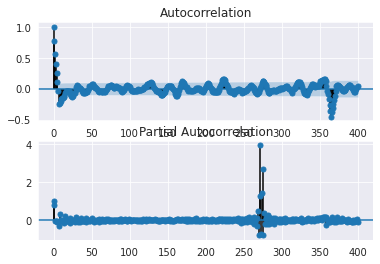

In [20]:
# acf for difference TS
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod000.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod000.resid.values.squeeze(), lags=400, ax=ax2)

**Questions**
   * What are candidates for $p$ and $q$?
      - $p$ ={1,...}
      - $P$ = {0, 1, 2}
      - $q$ = {1,...}
      - $Q$ = {0, 1}


**Note**: other options for $p$ and $q$ can be defined later

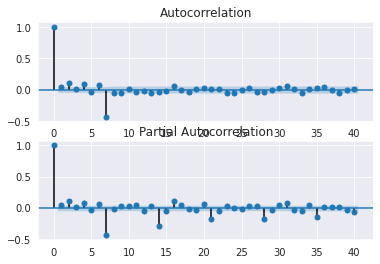

In [21]:
arima_mod100 = sm.tsa.ARIMA(endog = ts, order = (1,0,0), exog=exogs).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod100.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod100.resid.values.squeeze(), lags=40, ax=ax2)

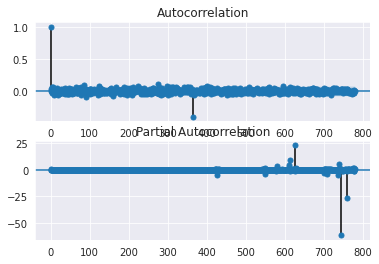

In [22]:
arima_mod107 = sm.tsa.ARIMA(endog = ts, order = (1,0,7), exog=exogs).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107.resid.values.squeeze(), lags=780, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107.resid.values.squeeze(), lags=780, ax=ax2)

**Questions**:
* How to compare this two models?
* What else should be considered?


In [23]:
print(arima_mod107.summary())

                              ARMA Model Results                              
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                     ARMA(1, 7)   Log Likelihood              -14816.949
Method:                       css-mle   S.D. of innovations           2945.546
Date:                Tue, 15 Feb 2022   AIC                          29661.897
Time:                        09:39:20   BIC                          29736.957
Sample:                    01-08-2011   HQIC                         29689.792
                         - 04-30-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 249.8817        nan        nan        nan         nan         nan
Temp1                 -95.4179     26.372     -3.618      0.000    -147.106     -43.730
Temp2           

In [24]:
print(arima_mod100.summary())

                              ARMA Model Results                              
Dep. Variable:          EnergyConsump   No. Observations:                 1574
Model:                     ARMA(1, 0)   Log Likelihood              -15230.202
Method:                       css-mle   S.D. of innovations           3853.641
Date:                Tue, 15 Feb 2022   AIC                          30474.404
Time:                        09:39:24   BIC                          30511.933
Sample:                    01-08-2011   HQIC                         30488.351
                         - 04-30-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 103.3950    631.542      0.164      0.870   -1134.405    1341.195
Temp1                 -89.7742     25.542     -3.515      0.000    -139.835     -39.714
Temp2           

In [25]:
# Use Seasonal ARIMA
arima_mod107_001 = sm.tsa.ARIMA(endog = ts, order = (1,0,7), seasonal_order = (0,0,1,365), exog=exogs).fit()
# arima_mod107_001  = sm.tsa.statespace.SARIMAX(ts, order=(1,0,7), seasonal_order=(0,0,1,365)).fit()
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod107_001.resid.values.squeeze(), lags=400, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod107_001.resid.values.squeeze(), lags=400, ax=ax2)

TypeError: ignored

### Residuals analysis.

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arima_mod107.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

* Residuals are stationary

In [ ]:
# Autocorrelation Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_mod107.resid.values, lags=80)['lb_pvalue'].values, 
              'critial':np.array([0.05]*80)}).set_index('lags').plot()
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

For lags 1-6 residuals are not correlated, but for lags 7 and grater seems residuals are correlated

In [ ]:
# Unbiasedness Darbin_Watson statistic
sm.stats.durbin_watson(arima_mod107.resid.values)

Residuals are not biased!

In [ ]:
# Normaliry test
stats.normaltest(arima_mod107.resid)

# q-qPlot
fig = plt.figure()
res = stats.probplot(exogs_var.resid, dist="norm", plot = pylab)

* Hypothesis of normality can be rejected

### Analysis of the coefficients

In [ ]:
print(arima_mod107.summary())

### Forecast for TS

In [ ]:
fig, ax = plt.subplots()
fig = arima_mod107.plot_predict(start='2015-01-01', end='2015-04-30', ax=ax)

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8),  linewidth=3.0)
# fig = arima_mod710_ex.plot_forecast(185)
frc = arima_mod107.forecast(steps = 13, exog = extra_exogs[extra_exogs.index>='2015-05-01'])

In [ ]:
frc_arimax = extra_exogs[extra_exogs.index>='2015-05-01']
frc_arimax['FRC'] = frc[0]
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

In [ ]:
# Practice: build the forecast of original TS


In [ ]:
# Practice: calculate MAPE for dates > 2015-05-01


## ARIMA for the original TS
**Question:** 
 * What is the period of seasonality for this TS? Another way to say: what are specifications of ARIMA model for this TS:
    - ARIMA (p,d,q)x(P,D,Q)_365
    - ARIMA (p,d,q)x(P,D,Q)_7

We will apply s=7 original ts
  - and we will use additional exogenious variable that correspond seasonality s=365

In [ ]:
energy_ts['EnergyConsump'].plot()

In [ ]:
# prepare additional features
ext_energy_ts = energy_ts.merge(energy_ts.shift(365).rename(columns={'EnergyConsump':'EnergyConsump365'})['EnergyConsump365'], how = 'left', left_index = True, right_index = True)
ext_energy_ts['EnergyConsump365'].plot()

In [ ]:
ext_energy_ts = ext_energy_ts[ext_energy_ts.index>'2011-01-01']
exogs = ext_energy_ts[['Temp1', 'Temp2', 'Saturday','Sunday', 'EnergyConsump365']][ext_energy_ts.index<'2015-05-01']

extra_exogs = ext_energy_ts[['Temp1', 'Temp2', 'Saturday','Sunday','EnergyConsump365']]
ts = ext_energy_ts[['EnergyConsump']][ext_energy_ts.index<'2015-05-01']

In [ ]:
def fit_arima_7(ts, p,d,q,P,D,Q, exogs_var): 
    try:
        mod = sm.tsa.statespace.SARIMAX(endog = ts, order=(p,d,q), seasonal_order=(P,D,Q,7), exog = exogs_var)
        results = mod.fit()
        return("sarimax_%i%i%i_%i%i%i: aic=%f, bic=%f, hqic=%f " % (p,d,q,P,D,Q, 
               results.aic, results.bic, results.hqic))
    except Exception:
        return ("sarimax_%i%i%i_%i%i%i: can't fit model " % (p,d,q,P,D,Q))    

In [ ]:
# try most popular parameters of ARIMA
from sklearn.model_selection import ParameterGrid

# we can't compare two ARIMA with different d, D using AIC, BIC, HQI
param_grid = {'p': [0, 1], 'd' : [1],
             'q': [0, 1], 'P' : [0, 1,2],
             'D': [1], 'Q' : [0,1, 2]}

grid = ParameterGrid(param_grid)

for params in grid:
    print(fit_arima_7(ts,params['p'], params['d'], params['q'], params['P'], params['D'], params['Q'], exogs_var = exogs))

**Questions**:
  * What is the best model?
    - <font color="green"> sarimax_101_012: aic=29752.238857, bic=29805.846256, hqic=29772.162066  </font>


### Residuals analysis
Analysis of residuals for the best model

In [ ]:
sarimax_101_012 = sm.tsa.statespace.SARIMAX(endog= ts, trend='n', 
                                            order=(1,1,1), seasonal_order=(0,1,2,7), exog=exogs).fit()
sarimax_101_012.plot_diagnostics()

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_101_012.resid.values.squeeze(), lags=780, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_101_012.resid.values.squeeze(), lags=780, ax=ax2)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarimax_101_012.resid.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarimax_101_012.resid.values.squeeze(), lags=80, ax=ax2)

In [ ]:
# Stationarity: Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(sarimax_101_012.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

* Residuals are stationary

In [ ]:
sm.stats.diagnostic.acorr_ljungbox(sarimax_101_012.resid.values, lags=80)[1]

In [ ]:
# Ljung-Box test 
pd.DataFrame({'lags':range(1,81,1), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(sarimax_101_012.resid.values, lags=80)[1], 
              'critial':np.array([0.05]*80)}).set_index('lags').plot()

For lags 1-6 residuals are not correlated

In [ ]:
# Unbiasedness test: Darbin_Watson statistic
sm.stats.durbin_watson(sarimax_101_012.resid.values)

Residuals are not biased!

In [ ]:
# Normality test
stats.normaltest(sarimax_101_012.resid)

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(sarimax_101_012.resid, dist="norm", plot=pylab)

* Hypothesis of normality can be rejected

### Analysis of the coefficients

In [ ]:
print(sarimax_101_012.summary())

**Conclusion:** 
Temp 2 variable should be exlcuded from Exog variables.

### Forecast for future
The predict command is first applied here to get in-sample predictions. We use the full_results=True argument to allow us to calculate confidence intervals (the default output of predict is just the predicted values).
With no other arguments, predict returns the one-step-ahead in-sample predictions for the entire sample.

In [ ]:
predict = sarimax_101_012.get_prediction()
predict_ci = predict.conf_int() # confidence interval

One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

In [ ]:
#  Dynamic predictions
predict_dy = sarimax_101_012.get_prediction(dynamic='2015-01-01')
predict_dy_ci = predict_dy.conf_int() # confidence interval

In [ ]:
# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Energy consumption', xlabel='Date')

# Plot data points
ts.loc['2015-01-01':, 'EnergyConsump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean['2015-01-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['2015-01-01':].plot(ax=ax, style='g', label='Dynamic forecast since 2015-01-01')
ci = predict_dy_ci.loc['2015-01-01':]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

In [ ]:
# forecast of future values
frc =sarimax_101_012.forecast(steps = 27, exog = extra_exogs[extra_exogs.index>='2015-05-01'].ffill())

In [ ]:
frc_arimax = extra_exogs.loc['2015-05-01':]
frc_arimax['FRC'] = frc
# frc_arimax['EnergyConsump'] = ts[ts.index>='2015-05-01'] 

In [ ]:
fig, ax = plt.subplots()

ax2, ax3 = ax.twinx(), ax.twinx()
ax2.set_ylabel('Holidays')
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.25))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('Temp2')
fig.subplots_adjust(right=0.75)

frc_arimax[['FRC']].tail(186).plot(ax = ax,marker = 'o', linewidth=2.0)
frc_arimax[['Saturday', 'Sunday']].tail(186).plot(ax = ax2, style='y', marker = '^', markersize = 10.0, linewidth=0.0)
frc_arimax['Temp2'].tail(186).plot(ax = ax3,  style='g-', marker='*')

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

# Conclusion
## Approach how to fit ARIMA

<img src = 'https://www.autobox.com/cms/images/easyblog_images/64/arimaredo.png'>


<!-- 
## Self-check questions
  1. -->


## HW2 preview    

**Materials**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model

* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model